<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [ ]:
# Import the Required Packages
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from tensorflow import keras
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, Embedding, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization, Bidirectional, SpatialDropout1D, LayerNormalization
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
%pip install tensorflow-addons
from tensorflow_addons.optimizers import AdaBelief
#Plotting graph
import string
%matplotlib inline

import csv
#from spellchecker import SpellChecker
import re
import nltk
import string
# importing jaccard distance
# and ngrams from nltk.util
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
nltk.download('words')
from nltk.corpus import words

gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Note: you may need to restart the kernel to use updated packages.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [ ]:
'''Change to your file path'''
weekang_dataset = pd.read_csv("disney+_reviews.csv")
ziren_dataset = pd.read_csv("facebook_reviews.csv")
xihe_dataset = pd.read_csv("microsoftTeams_reviews.csv")
longt_dataset = pd.read_csv("wildrift_reviews.csv")
hasanah_dataset = pd.read_csv("netflix_reviews2.csv")


# ======================================== CHANGE TO YOUR NAME ========================================
dataset = weekang_dataset

In [ ]:
# Remove empty reviews 

# Shows the number of empty reviews in content column in the dataframe
print(str(dataset['content'].isnull().sum()) + " empty cells in content column")

# Drop missing values from dataframe
dataset = dataset.dropna(subset=['content'],how = 'any')

print(str(dataset['content'].isnull().sum()) + " empty cells in content column after removal")

0 empty cells in content column
0 empty cells in content column after removal


In [ ]:
# Remove duplicate entries in the dataframe only in the content column

# Check rows for duplicated content (searches content column only!)
print("It is " + str(dataset['content'].duplicated().any().copy()) + " that there are duplicate contents")

# Drop rows with duplicated content data 
# The first of the duplicates are kep
dataset2 = dataset.drop_duplicates(subset=['content'], keep='first').copy()

# Check if the duplicates are removed 
print("It is " + str(dataset2['content'].duplicated().any()) + " that there are duplicate contents after cleaning")

print("Number of columns left:")
dataset2.score.value_counts()

It is True that there are duplicate contents
It is False that there are duplicate contents after cleaning
Number of columns left:


4    10198
1    10196
5    10191
3    10189
2    10185
Name: score, dtype: int64

In [ ]:
from IPython.display import clear_output
from nltk.stem import WordNetLemmatizer

review_content = dataset2['content']
review_labels = dataset2['score']
csv_len = len(review_content.tolist())

# ======================================== CHANGE TO YOUR FILENAME ========================================
f = open('disney+_reviews_filtered.csv', 'w+', encoding="utf-8" , newline='')

words_list = []
def read_words():
    w = open('words.txt', 'r', encoding='utf-8')
    lines = w.readlines()
    for line in lines:
        line = line.replace("\n", "")
        words_list.append(line.lower())
    w.close()
    
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(sentence):
    lemma_word = []
    #print(sentence)
    for w in sentence:
        w = w.lower()
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "v")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "n")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
        lemma_word.append(word3)
    #print(lemma_word)
    return lemma_word    

before_lem = ["was", "feet", "jumping", "better", "stripes"]
after_lem = lemmatizer(before_lem)
print("Before lemmentization")
print(before_lem)
print("After lemmentization")
print(after_lem)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


writer = csv.writer(f)
header = ['content', 'score']
writer.writerow(header)

read_words()

filtered_reviews = []
one_count = 0
two_count = 0 
three_count = 0
four_count = 0
five_count = 0

count = 0
stop = stopwords.words('english')
print("Starting.. ETA: 5.5hrs")

# Filter words
for sentence, score in zip(review_content.tolist(), review_labels.tolist()):
    if score == 1 and one_count != 10000:
        one_count += 1
    elif score == 2 and two_count != 10000:
        two_count += 1
    elif score == 3 and three_count != 10000:
        three_count += 1
    elif score == 4 and four_count != 10000:
        four_count += 1
    elif score == 5 and five_count != 10000:
        five_count += 1
    else:
        continue
    sentence = remove_emojis(sentence)
    seperated_sentence = sentence.split(" ")
    filtered_sentence = []
    for word in seperated_sentence:
        # remove punctuation
        for punc in string.punctuation:
            if punc in word:
                word = word.replace(punc, '')
        word = word.lower()
        # adds coorect word to list
        if (word in stop):
            continue
        elif (word in words_list):
            filtered_sentence.append(word)
        
        # loop for finding correct spellings
        # based on jaccard distance
        # and printing the correct word
        elif (len(word) > 1 and word.isalpha() and re.compile(r'[a-z]')):
            if (('a' <= word[0] <= "z" or 'A' <= word[0] <='Z') and (word.upper() != word.lower())):     
                temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w) for w in words_list if w[0]==word[0]]
                filtered_sentence.append(sorted(temp, key = lambda val:val[0])[0][1])
        
    filtered_sentence = lemmatizer(filtered_sentence)
    filtered_sentence = ' '.join(filtered_sentence)
    if (filtered_sentence != ""):
        count += 1
        filtered_reviews.append([filtered_sentence, score])     
        print("Score: " + str(score) + " \n#" + str(count))
        print(filtered_sentence)
    else:
        if score == 1:
            one_count -= 1
        elif score == 2:
            two_count -= 1
        elif score == 3:
            three_count -= 1
        elif score == 4:
            four_count -= 1
        elif score == 5:
            five_count -= 1
    
writer.writerows(filtered_reviews)

f.close()
clear_output(wait=True)
print("Data cleaning completed")

Data cleaning completed


### 1.2 Data Processing


In [ ]:
new_dataset = pd.read_csv("disney+_reviews_filtered.csv")
new_dataset.score.value_counts()

5    10000
4    10000
3    10000
2    10000
1    10000
Name: score, dtype: int64

In [ ]:
# Convert the content and scores into numeric tensors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
review_content = new_dataset['content'].astype("str")
review_labels = new_dataset['score']

# Convert labels to numpy arrays
labels = to_categorical(review_labels).tolist()

for label in labels:
    label.pop(0)
labels = np.array(labels)
    
# Initialize tokenizer
vocab_size = 10000
embedding_dim = 256
max_length = 60
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(review_content)
sequences = tokenizer.texts_to_sequences(review_content)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = np.array(pad_sequences(sequences, maxlen=max_length, truncating = trunc_type))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 13380 unique tokens.
Shape of data tensor: (50000, 60)
Shape of label tensor: (50000, 5)


### 1.3 Data Sampling

In [ ]:
# Split the X & y into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

x_train_split = x_train[:20000]
y_train_split = y_train[:20000]
x_val = x_train[20000:]
y_val = y_train[20000:]

print(len(x_train_split))
print(len(x_test))
print(len(x_val))

print(x_train_split[0])
print(x_test[0])
print(x_val[0])

20000
10000
20000
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   9 504 689  55 225 245 554 892 154
  22 979  18 700  32  60]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   24
   37  124    1  131   49   93  249  124 6704  263   30    4    1   22
   56  288  261   28 3514    6    4  288  119  461  703 2128 1820 4726
 2784    1  161  452]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   35    7   47 1314
    3   70  145   78    5  228   60   20   49   23  104    5  830   33
  546  441   48   23]


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Model #1  (Student Name: Wee Kang)

In [ ]:
#     head, sep, tail = text.partition('_')
#     word = head
#     for c in word:
#         if c in string.punctuation:
#             word = word.replace(c, '')

import os
glove_dir = 'C:\\Users\\jason\\Desktop\\Y2\\Sem1\\DL\\ASG\\2\\Group'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'crawl-300d-2M.vec'), encoding="utf8")

count = 0
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        count += 1
    
f.close()
print("Number of fails: ", count)
print('Found %s word vectors.' % len(embeddings_index))

Number of fails:  0
Found 1999996 word vectors.


In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
# Build the Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) #receive word embedding as input
model.add(Bidirectional(GRU(64, activation='tanh', return_sequences=True)))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128, activation='tanh', return_sequences=True)))
model.add(SpatialDropout1D(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 60, 300)           3000000   
                                                                 
 bidirectional_23 (Bidirecti  (None, 60, 128)          140544    
 onal)                                                           
                                                                 
 spatial_dropout1d_15 (Spati  (None, 60, 128)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_24 (Bidirecti  (None, 60, 256)          198144    
 onal)                                                           
                                                                 
 spatial_dropout1d_16 (Spati  (None, 60, 256)          0         
 alDropout1D)                                        

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
# Train the Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train_split, y_train_split,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )])

Epoch 1/50
625/625 [==============================] - 23s 32ms/step - loss: 1.3881 - acc: 0.3864 - val_loss: 1.2277 - val_acc: 0.4697
Epoch 2/50
625/625 [==============================] - 18s 28ms/step - loss: 1.2139 - acc: 0.4766 - val_loss: 1.1685 - val_acc: 0.4981
Epoch 3/50
625/625 [==============================] - 20s 32ms/step - loss: 1.1707 - acc: 0.5002 - val_loss: 1.1462 - val_acc: 0.5107
Epoch 4/50
625/625 [==============================] - 21s 34ms/step - loss: 1.1442 - acc: 0.5115 - val_loss: 1.1315 - val_acc: 0.5160
Epoch 5/50
625/625 [==============================] - 20s 33ms/step - loss: 1.1294 - acc: 0.5203 - val_loss: 1.1173 - val_acc: 0.5210
Epoch 6/50
625/625 [==============================] - 20s 32ms/step - loss: 1.1144 - acc: 0.5216 - val_loss: 1.1251 - val_acc: 0.5170
Epoch 7/50
625/625 [==============================] - 19s 30ms/step - loss: 1.1019 - acc: 0.5325 - val_loss: 1.1059 - val_acc: 0.5250
Epoch 8/50
625/625 [==============================] - 22s 35ms

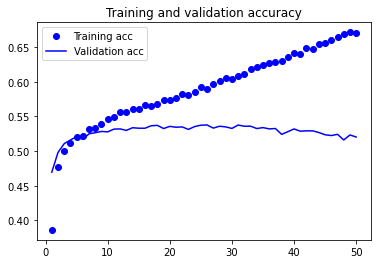

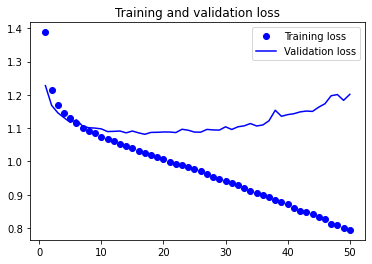

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save('text_model_weekang.h5')
model.save_weights('text_model_weekang_weights.h5')

### Model #2  (Student Name: Lim Long Teck)

In [ ]:
# Build the Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) #receive word embedding as input
model.add(Bidirectional(GRU(512, return_sequences=True)))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(GRU(512, return_sequences=True)))
model.add(Bidirectional(GRU(512, return_sequences=True)))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Bidirectional(GRU(32)))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 60, 100)           1000000   
                                                                 
 bidirectional_53 (Bidirecti  (None, 60, 1024)         1886208   
 onal)                                                           
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 60, 1024)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_54 (Bidirecti  (None, 60, 1024)         4724736   
 onal)                                                           
                                                                 
 bidirectional_55 (Bidirecti  (None, 60, 1024)         4724736   
 onal)                                               

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 60, 100)           1000000   
                                                                 
 bidirectional_53 (Bidirecti  (None, 60, 1024)         1886208   
 onal)                                                           
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 60, 1024)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_54 (Bidirecti  (None, 60, 1024)         4724736   
 onal)                                                           
                                                                 
 bidirectional_55 (Bidirecti  (None, 60, 1024)         4724736   
 onal)                                               

In [ ]:
# Train the Model
model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train_split, y_train_split,
                    epochs=80,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/80
157/157 [==============================] - 59s 305ms/step - loss: 1.5608 - acc: 0.3099 - val_loss: 1.4901 - val_acc: 0.3696
Epoch 2/80
157/157 [==============================] - 47s 303ms/step - loss: 1.4551 - acc: 0.3721 - val_loss: 1.4380 - val_acc: 0.3817
Epoch 3/80
157/157 [==============================] - 50s 318ms/step - loss: 1.4181 - acc: 0.3943 - val_loss: 1.4016 - val_acc: 0.4002
Epoch 4/80
157/157 [==============================] - 48s 308ms/step - loss: 1.3941 - acc: 0.4062 - val_loss: 1.3774 - val_acc: 0.4133
Epoch 5/80
157/157 [==============================] - 48s 304ms/step - loss: 1.3725 - acc: 0.4155 - val_loss: 1.3536 - val_acc: 0.4267
Epoch 6/80
157/157 [==============================] - 48s 308ms/step - loss: 1.3517 - acc: 0.4238 - val_loss: 1.3434 - val_acc: 0.4270
Epoch 7/80
157/157 [==============================] - 47s 300ms/step - loss: 1.3395 - acc: 0.4299 - val_loss: 1.3368 - val_acc: 0.4329
Epoch 8/80
157/157 [==============================] - 4

In [ ]:
# Save the Model
model.save_weights('longteck_pre_trained_word2vec_model.h5')

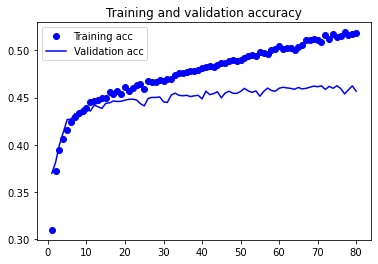

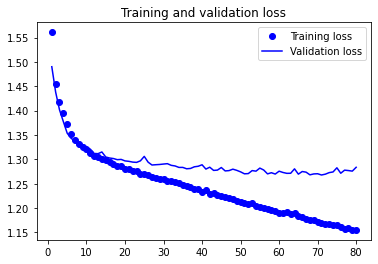

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save('text_model_LongTeck.h5')

### Model #3  (Student Name: Han Xihe)

In [ ]:
# Try lower learning rate to improve generalization performance

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True, unroll=True))
model.add(LSTM(64, return_sequences=True, unroll=True))
model.add(LSTM(32, return_sequences=True, unroll=True))
model.add(LSTM(16, unroll=True))
model.add(LayerNormalization())
model.add(Dense(5, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 100)           1000000   
                                                                 
 lstm_24 (LSTM)              (None, 60, 128)           117248    
                                                                 
 lstm_25 (LSTM)              (None, 60, 64)            49408     
                                                                 
 lstm_26 (LSTM)              (None, 60, 32)            12416     
                                                                 
 lstm_27 (LSTM)              (None, 16)                3136      
                                                                 
 layer_normalization_6 (Laye  (None, 16)               32        
 rNormalization)                                                 
                                                      

In [ ]:
# Train the Model
model.compile(optimizer = Adamax(learning_rate=2e-5),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train_split, y_train_split,
                    epochs=110,
                    batch_size=256,
                    validation_data=(x_val, y_val)
                    #callbacks=[earlyStoppingXihe]
                   )

Epoch 1/110
79/79 [==============================] - 42s 198ms/step - loss: 1.6783 - acc: 0.2411 - val_loss: 1.5899 - val_acc: 0.2814
Epoch 2/110
79/79 [==============================] - 12s 155ms/step - loss: 1.5623 - acc: 0.2898 - val_loss: 1.5314 - val_acc: 0.3083
Epoch 3/110
79/79 [==============================] - 12s 153ms/step - loss: 1.5183 - acc: 0.3157 - val_loss: 1.5007 - val_acc: 0.3294
Epoch 4/110
79/79 [==============================] - 12s 156ms/step - loss: 1.4896 - acc: 0.3323 - val_loss: 1.4760 - val_acc: 0.3411
Epoch 5/110
79/79 [==============================] - 12s 147ms/step - loss: 1.4660 - acc: 0.3471 - val_loss: 1.4550 - val_acc: 0.3510
Epoch 6/110
79/79 [==============================] - 12s 150ms/step - loss: 1.4457 - acc: 0.3560 - val_loss: 1.4370 - val_acc: 0.3615
Epoch 7/110
79/79 [==============================] - 13s 163ms/step - loss: 1.4277 - acc: 0.3650 - val_loss: 1.4223 - val_acc: 0.3711
Epoch 8/110
79/79 [==============================] - 13s 170ms

Epoch 62/110
79/79 [==============================] - 12s 151ms/step - loss: 1.2218 - acc: 0.4848 - val_loss: 1.2348 - val_acc: 0.4766
Epoch 63/110
79/79 [==============================] - 12s 150ms/step - loss: 1.2208 - acc: 0.4848 - val_loss: 1.2338 - val_acc: 0.4772
Epoch 64/110
79/79 [==============================] - 12s 151ms/step - loss: 1.2188 - acc: 0.4861 - val_loss: 1.2322 - val_acc: 0.4781
Epoch 65/110
79/79 [==============================] - 12s 151ms/step - loss: 1.2176 - acc: 0.4857 - val_loss: 1.2315 - val_acc: 0.4785
Epoch 66/110
79/79 [==============================] - 12s 150ms/step - loss: 1.2159 - acc: 0.4875 - val_loss: 1.2299 - val_acc: 0.4807
Epoch 67/110
79/79 [==============================] - 12s 156ms/step - loss: 1.2145 - acc: 0.4871 - val_loss: 1.2287 - val_acc: 0.4809
Epoch 68/110
79/79 [==============================] - 12s 158ms/step - loss: 1.2132 - acc: 0.4875 - val_loss: 1.2274 - val_acc: 0.4807
Epoch 69/110
79/79 [==============================] - 1

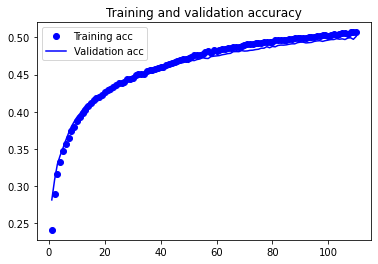

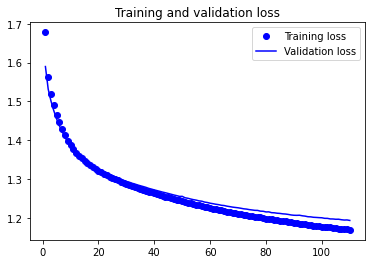

In [ ]:
graph()
model.save('text_model_Xihe_6.h5')

In [ ]:
# Save the Model
model.save('text_model_Xihe.h5')

### Model #4  (Student Name: Yong Zi Ren)

In [ ]:
# Build the Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim , input_length=max_length))
model.add(GRU(64, return_sequences=True, kernel_regularizer=regularizers.L2(1e-5), dropout = 0.5))
model.add(Dropout(0.5))
model.add(GroupNormalization())
model.add(GRU(128, kernel_regularizer=regularizers.L2(1e-5), dropout = 0.5))
model.add(Dropout(0.5))
model.add(GroupNormalization())
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 128)           1280000   
                                                                 
 gru_12 (GRU)                (None, 60, 64)            37248     
                                                                 
 dropout_10 (Dropout)        (None, 60, 64)            0         
                                                                 
 group_normalization_10 (Gro  (None, 60, 64)           128       
 upNormalization)                                                
                                                                 
 gru_13 (GRU)                (None, 128)               74496     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                      

In [ ]:
# Train the Model
model.compile(optimizer = AdaBelief(),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train_split, y_train_split,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_acc',
                        patience=10,
                        restore_best_weights=True
                    )])

Epoch 1/50
625/625 [==============================] - 24s 30ms/step - loss: 1.8788 - acc: 0.2309 - val_loss: 1.5928 - val_acc: 0.2907
Epoch 2/50
625/625 [==============================] - 18s 29ms/step - loss: 1.5696 - acc: 0.2959 - val_loss: 1.4488 - val_acc: 0.3654
Epoch 3/50
625/625 [==============================] - 18s 28ms/step - loss: 1.4237 - acc: 0.3649 - val_loss: 1.3573 - val_acc: 0.4031
Epoch 4/50
625/625 [==============================] - 18s 29ms/step - loss: 1.3657 - acc: 0.3901 - val_loss: 1.3683 - val_acc: 0.4111
Epoch 5/50
625/625 [==============================] - 18s 29ms/step - loss: 1.3236 - acc: 0.4171 - val_loss: 1.3433 - val_acc: 0.4248
Epoch 6/50
625/625 [==============================] - 18s 29ms/step - loss: 1.3048 - acc: 0.4299 - val_loss: 1.4222 - val_acc: 0.3568
Epoch 7/50
625/625 [==============================] - 17s 28ms/step - loss: 1.2808 - acc: 0.4417 - val_loss: 1.3376 - val_acc: 0.4160
Epoch 8/50
625/625 [==============================] - 18s 29ms

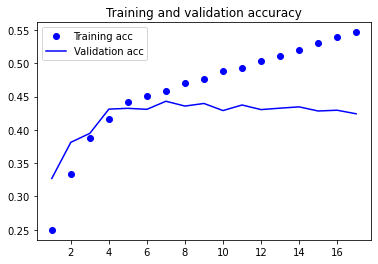

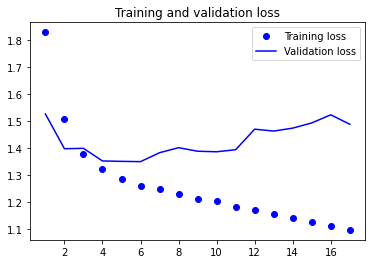

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
model.save_weights('pre_trained_glove_model_4.h5')

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save('text_model_ZiRen.h5')

### Model #5  (Student Name: Hasanah)

In [ ]:
# Build the Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(32,dropout = 0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(GRU(32,dropout = 0.5, recurrent_dropout=0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 60, 128)           1280000   
                                                                 
 gru_34 (GRU)                (None, 60, 32)            15552     
                                                                 
 gru_35 (GRU)                (None, 32)                6336      
                                                                 
 dense_20 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1,302,053
Trainable params: 1,302,053
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the Model
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train_split, y_train_split,
                    epochs=20,
                    batch_size=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
1000/1000 [==============================] - 53s 49ms/step - loss: 1.5908 - acc: 0.2637 - val_loss: 1.5291 - val_acc: 0.3200
Epoch 2/20
1000/1000 [==============================] - 54s 54ms/step - loss: 1.4440 - acc: 0.3529 - val_loss: 1.3818 - val_acc: 0.3763
Epoch 3/20
1000/1000 [==============================] - 55s 55ms/step - loss: 1.3652 - acc: 0.3860 - val_loss: 1.3367 - val_acc: 0.4036
Epoch 4/20
1000/1000 [==============================] - 54s 54ms/step - loss: 1.3292 - acc: 0.4099 - val_loss: 1.3140 - val_acc: 0.4182
Epoch 5/20
1000/1000 [==============================] - 60s 60ms/step - loss: 1.3046 - acc: 0.4277 - val_loss: 1.2997 - val_acc: 0.4293
Epoch 6/20
1000/1000 [==============================] - 59s 59ms/step - loss: 1.2838 - acc: 0.4401 - val_loss: 1.2879 - val_acc: 0.4349
Epoch 7/20
1000/1000 [==============================] - 59s 59ms/step - loss: 1.2674 - acc: 0.4500 - val_loss: 1.2748 - val_acc: 0.4439
Epoch 8/20
1000/1000 [==========================

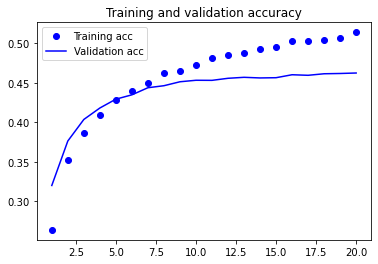

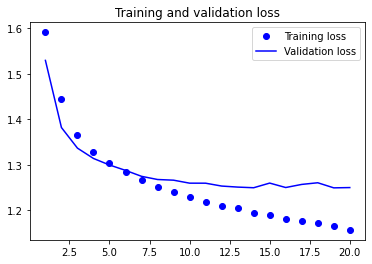

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
model.save_weights('pre_trained_glove_model_5.h5')

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save('text_model_hasanah.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [ ]:
# Model #1 (replicate where necessary for other models)
model1 = keras.models.load_model('text_model_weekang.h5')

print("============== Wee kang\'s model on Hasanah dataset ==============")
test_loss, test_acc = model1.evaluate(x_test, y_test, steps=50)
print('test acc:', test_acc)

============== Wee kang's model on Hasanah dataset ==============
50/50 [==============================] - 3s 26ms/step - loss: 2.0610 - acc: 0.2006
test acc: 0.20059999823570251


In [ ]:
# Model #2 (replicate where necessary for other models)
print("=============== Long Teck's model on Wee Kang dataset ===============")
model2 = keras.models.load_model('text_model_LongTeck_9.h5')

test_loss, test_acc = model2.evaluate(x_val, y_val, steps=50)
print('test acc:', test_acc)

=============== Long Teck's model on Wee Kang dataset ===============
50/50 [==============================] - 21s 348ms/step - loss: 1.9110 - acc: 0.2332
test acc: 0.23315000534057617


In [ ]:
# Model #3 (replicate where necessary for other models)
model3 = keras.models.load_model('text_model_Xihe_6.h5')
print("=============== Xihe's model on Zi Ren dataset ==============")
test_loss, test_acc = model3.evaluate(x_val, y_val, steps=50)
print('test acc:', test_acc)

=============== Xihe's model on Zi Ren dataset ==============
50/50 [==============================] - 5s 39ms/step - loss: 1.9902 - acc: 0.1928
test acc: 0.1928499937057495


In [ ]:
# Model #4 (replicate where necessary for other models)
model4 = keras.models.load_model('text_model_ZiRen.h5')
print("============== Zi Ren's model on Long Teck dataset =============")
test_loss, test_acc = model4.evaluate(x_val, y_val, steps=50)
print('test acc:', test_acc)

============== Zi Ren's model on Long Teck dataset =============
50/50 [==============================] - 2s 17ms/step - loss: 2.4709 - acc: 0.2054
test acc: 0.20540976524353027


In [ ]:
# Model #5 (replicate where necessary for other models)
model5 = keras.models.load_model('text_model_hasanah.h5')

print("============== Hasanah\'s model on Xihe dataset ==============")
test_loss, test_acc = model5.evaluate(x_test, y_test, steps=50)
print('test acc:', test_acc)

============== Hasanah's model on Xihe dataset ==============
50/50 [==============================] - 2s 21ms/step - loss: 2.0146 - acc: 0.2106
test acc: 0.21060000360012054


In [ ]:
# Save the Best Model
model1.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
best_model = keras.models.load_model('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input("")])

I hate this app, it keeps crashing


In [ ]:
# convert the user input into numeric tensor

# Initialize tokenizer
vocab_size = 10000
embedding_dim = 32
max_length = 60
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text_input)
sequences = tokenizer.texts_to_sequences(text_input)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_length)

print(text_input)
print('Shape of data tensor:', data.shape)

Found 7 unique tokens.
['I hate this app, it keeps crashing']
Shape of data tensor: (1, 60)


In [ ]:
# show the model output using predict function
predictions = best_model.predict(data)
print("This review's rating is: " + str(predictions.argmax()))

1/1 [==============================] - 2s 2s/step
This review's rating is: 2


In [ ]:
# takes the user input
text_input = np.array([input("")])

I love this app as it makes my life productive


In [ ]:
# convert the user input into numeric tensor

# Initialize tokenizer
vocab_size = 10000
embedding_dim = 32
max_length = 60
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text_input)
sequences = tokenizer.texts_to_sequences(text_input)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_length)

print(text_input)
print('Shape of data tensor:', data.shape)

Found 10 unique tokens.
['I love this app as it makes my life productive']
Shape of data tensor: (1, 60)


In [ ]:
# show the model output using predict function
predictions = best_model.predict(data)
print("This review's rating is: " + str(predictions.argmax()))

1/1 [==============================] - 0s 35ms/step
This review's rating is: 2
